In [1]:
import h5py
import numpy as np

# Load the HDF5 dataset
filename = 'reaction_diffusion_training_32x32_coarse.h5'
with h5py.File(filename, 'r') as h5file:
    d1_values = h5file['d1'][:]
    beta_values = h5file['beta'][:]
    t_values = h5file['t'][:]
    x_values = h5file['x'][:]
    y_values = h5file['y'][:]
    u_data = h5file['u'][:]  # Shape: (num_samples, len(t), n, n)
    v_data = h5file['v'][:]  # Shape: (num_samples, len(t), n, n)

print(f"Loaded dataset with {u_data.shape[0]} samples.")

Loaded dataset with 50 samples.


In [2]:
# Reshape data into 2D matrix (num_samples * time_steps, grid_points)
num_samples, time_steps, n, _ = u_data.shape
grid_points = n * n
u_snapshots = u_data[:num_samples,:].reshape(num_samples * time_steps, grid_points).T
# v_snapshots = v_data[:num_samples,:].reshape(num_samples * time_steps, grid_points).T

# Combine u and v data (optional: POD on combined fields)
# combined_snapshots = np.vstack([u_snapshots, v_snapshots])  # Shape: (2 * grid_points, num_snapshots)

In [3]:
from sklearn.utils.extmath import randomized_svd

# Randomized SVD
n_components = 100  # Number of dominant modes to compute
U, Sigma, VT = randomized_svd(u_snapshots[:,::3], n_components=n_components, random_state=42)

print(f"Computed {U.shape[1]} approximate POD modes using randomized SVD.")

# Extract POD modes and singular values
POD_modes = U  # Each column is a POD mode
singular_values = Sigma  # Singular values
time_coefficients = VT.T  # Time-dependent coefficients

print(f"Computed {POD_modes.shape[1]} POD modes.")

Computed 100 approximate POD modes using randomized SVD.
Computed 100 POD modes.


In [4]:
# Load the HDF5 dataset
filename = 'reaction_diffusion_testing_32x32_coarse.h5'

with h5py.File(filename, 'r') as h5file:
    d1_values_test   = h5file['d1'][:]
    beta_values_test = h5file['beta'][:]
    t_values_test    = h5file['t'][:]
    x_values_test    = h5file['x'][:]
    y_values_test    = h5file['y'][:]
    u_data_test      = h5file['u'][:]  # Shape: (num_samples, len(t), n, n)
    v_data_test      = h5file['v'][:]  # Shape: (num_samples, len(t), n, n)

print(f"Loaded dataset with {u_data_test.shape[0]} samples.")



Loaded dataset with 50 samples.


In [5]:
print(u_data[1,:])
print(u_data_test[1,:])

[[[-7.03584678e-01 -9.48190763e-01 -9.91476813e-01 ...  3.55998255e-01
   -2.48164939e-03 -3.78151058e-01]
  [-9.25743905e-01 -9.95630506e-01 -8.46025786e-01 ...  7.67264940e-01
    4.73598298e-01  9.33803840e-02]
  [-9.99996921e-01 -8.80740968e-01 -5.59179866e-01 ...  9.80725467e-01
    8.29046366e-01  5.33141979e-01]
  ...
  [-5.39754376e-01 -8.50628989e-01 -9.92492113e-01 ... -2.86419102e-01
    1.95390784e-01  6.41330267e-01]
  [-1.30283266e-01 -5.33141979e-01 -8.29046366e-01 ...  1.22308652e-01
    5.59179866e-01  8.80740968e-01]
  [ 3.17701552e-01 -9.33803840e-02 -4.73598298e-01 ...  5.25766415e-01
    8.46025786e-01  9.95630506e-01]]

 [[-5.28634421e-01 -8.04113178e-01 -9.52795158e-01 ...  2.22564542e-01
   -1.18702851e-01 -4.31504997e-01]
  [-8.16751077e-01 -9.89934383e-01 -9.34787946e-01 ...  5.91128513e-01
    2.51228001e-01 -1.47694788e-01]
  [-9.12240698e-01 -9.57359251e-01 -7.08263877e-01 ...  9.04549224e-01
    6.91469685e-01  3.05122900e-01]
  ...
  [-3.08784533e-01 -7.1

In [6]:
print(U.shape)

(1024, 100)


In [7]:
print(u_snapshots.shape)

(1024, 20050)


In [8]:
# Reshape training data into a 2D matrix (num_samples * time_steps, grid_points)
num_samples_train, time_steps_train, n_train, _ = u_data.shape
grid_points_train = n_train * n_train

# Subsample training data
num_samples_to_use = 5

end_index = (num_samples_to_use * (time_steps_train))

snapshots_train = u_data[:num_samples_to_use,:].reshape(end_index, grid_points_train).T

# Compute time coefficients for training data
time_coefficients_train = U.T @ snapshots_train[:, :end_index]

# Reconstruct training snapshots
snapshots_reconstructed_train = U @ time_coefficients_train

# Calculate reconstruction error for training data
reconstruction_error_train = (
    np.linalg.norm(snapshots_train[:, :end_index] - snapshots_reconstructed_train)
    / np.linalg.norm(snapshots_train[:, :end_index])
)

print(f"Train Reconstruction Error: {reconstruction_error_train:.12f}")

# Reshape testing data into a 2D matrix (num_samples * time_steps, grid_points)
num_samples_test, time_steps_test, n_test, _ = u_data_test.shape
grid_points_test = n_test * n_test

# Subsample testing data
snapshots_test = u_data_test[:num_samples_to_use,:].reshape(end_index, grid_points_test).T

# Compute time coefficients for testing data
time_coefficients_test = U.T @ snapshots_test[:, :end_index]

# Reconstruct testing snapshots
snapshots_reconstructed_test = U @ time_coefficients_test

# Calculate reconstruction error for testing data
reconstruction_error_test = (
    np.linalg.norm(snapshots_test[:, :end_index] - snapshots_reconstructed_test)
    / np.linalg.norm(snapshots_test[:, :end_index])
)

print(f"Test Reconstruction Error: {reconstruction_error_test:.12f}")

Train Reconstruction Error: 0.009331547876
Test Reconstruction Error: 0.019418960826


In [9]:
print(Sigma)

[1177.31268079 1169.12563901  356.31386555  355.97578504  248.27227101
  242.53505266  139.00491028  137.75737668   83.22670874   81.58077233
   80.16045517   74.32671984   52.46502843   49.71389056   46.53957773
   42.60687026   40.44657178   37.7543971    37.28864697   35.21467118
   32.88776582   30.76458754   30.39542252   29.71156331   27.62790717
   26.66656292   25.3631848    24.07496767   23.2597139    22.60191823
   21.576279     21.09791859   20.84480414   19.72499408   19.1785858
   18.00510479   17.31919384   17.03931543   16.4107759    16.01798824
   15.46493915   14.90989873   14.30112669   13.55944404   13.37924231
   13.04261001   12.82157611   12.36381105   12.09497643   11.8347913
   11.34244419   11.14344364   10.36859761   10.31342681   10.09585762
    9.72326349    9.37317722    9.27832247    8.86461514    8.83843748
    8.54787495    8.19529792    8.01468557    7.79893997    7.67385566
    7.26517375    7.11822693    6.99494364    6.89771411    6.65296358
    6.58

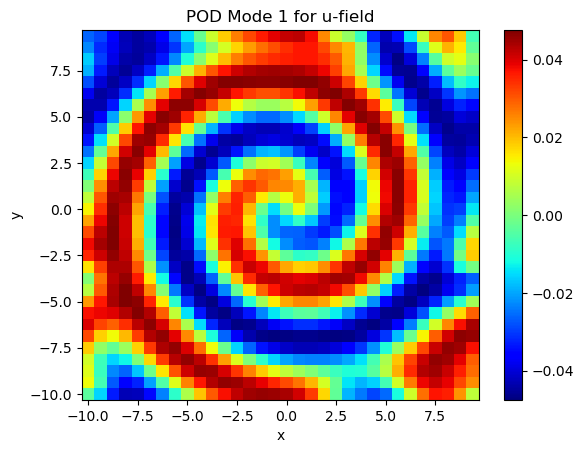

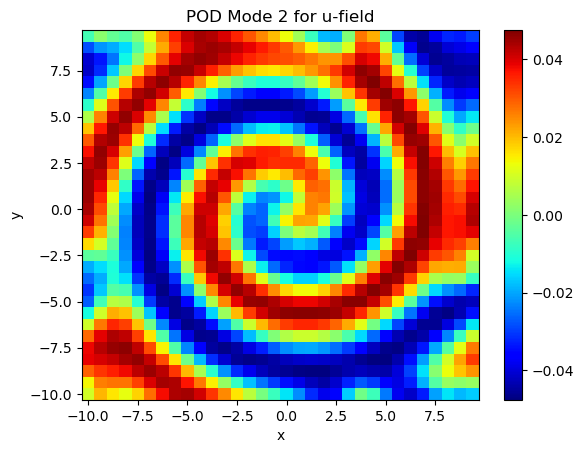

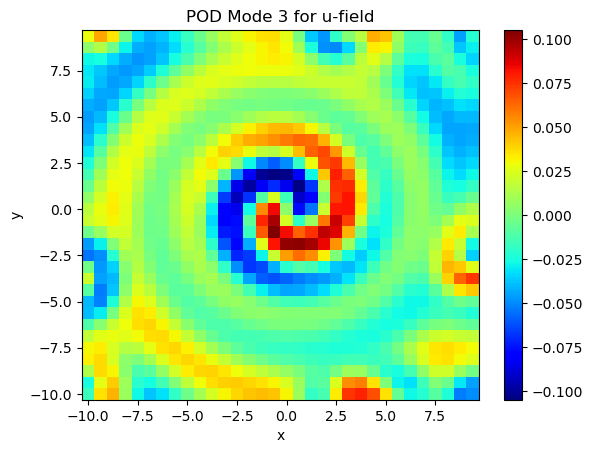

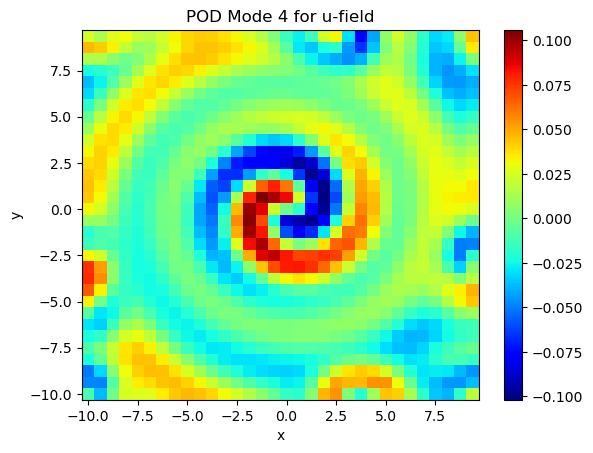

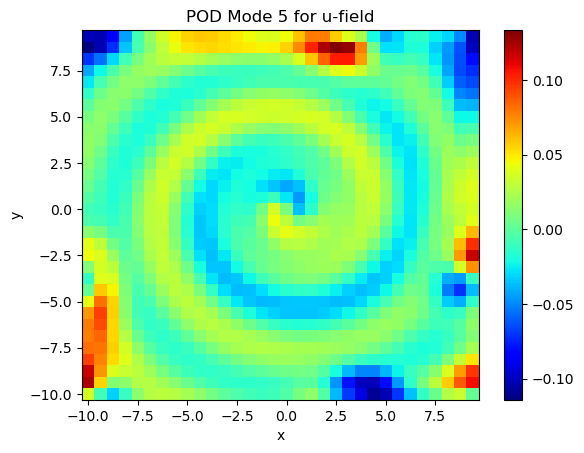

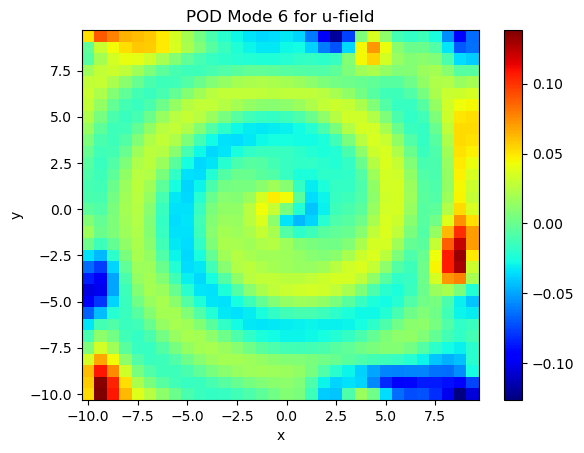

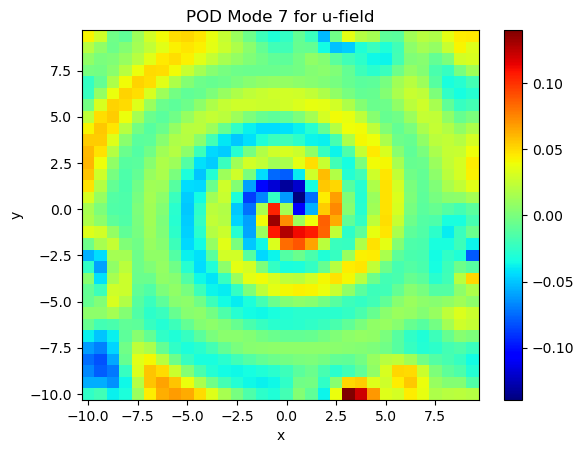

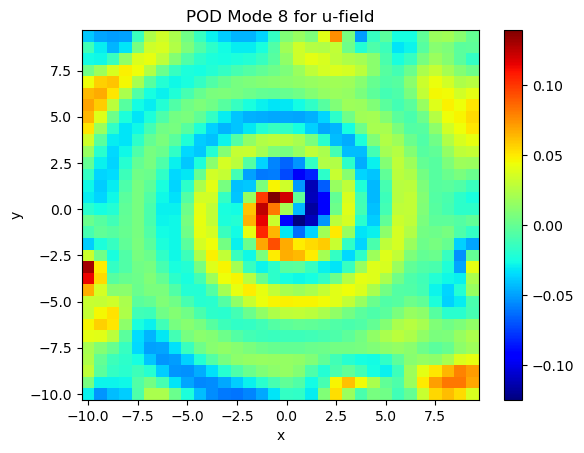

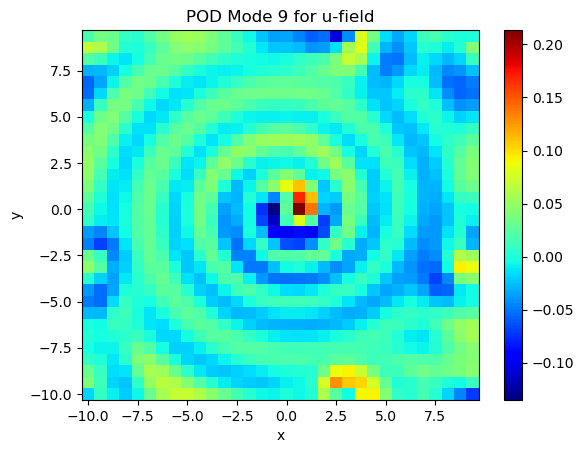

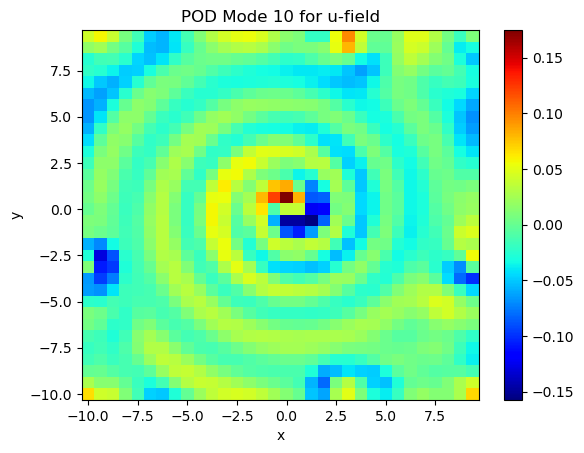

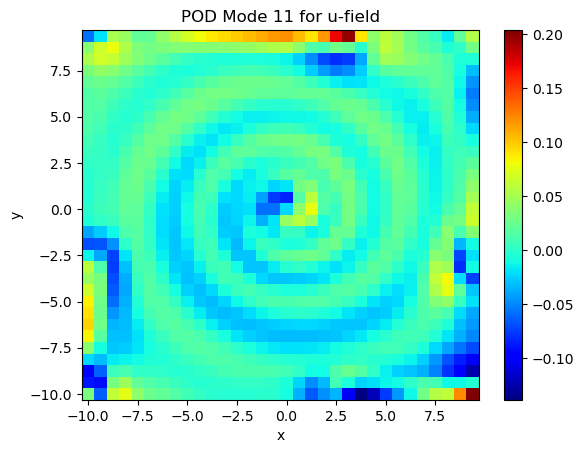

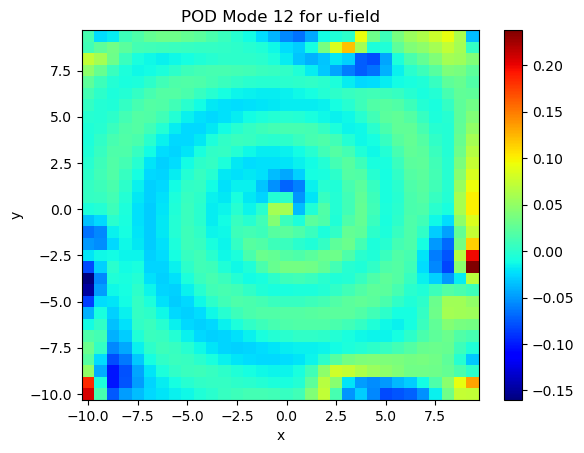

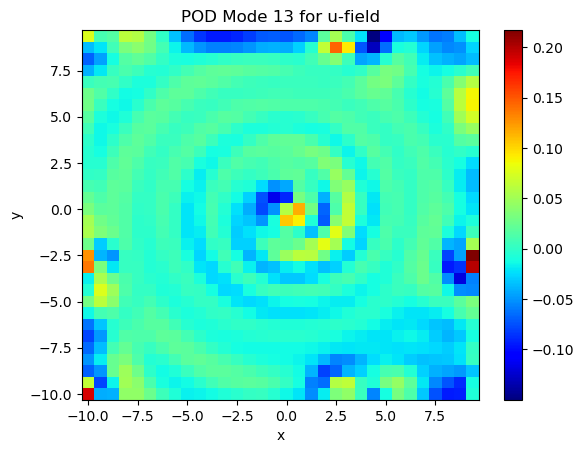

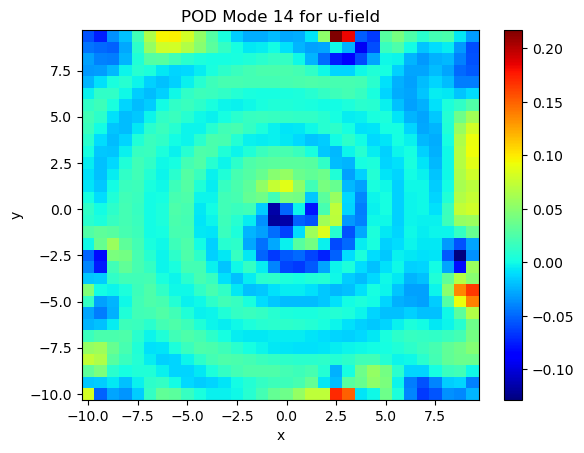

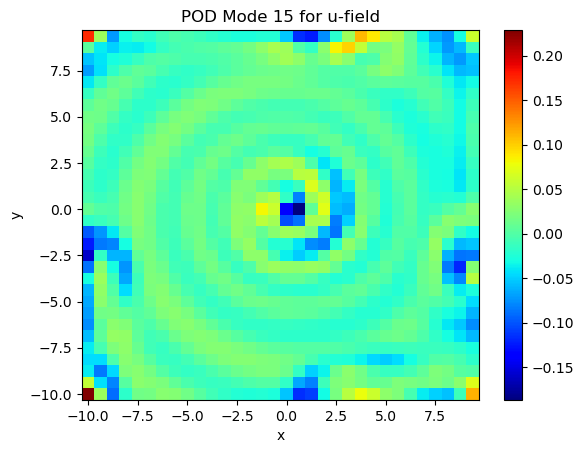

In [10]:
import matplotlib.pyplot as plt

# Reshape and visualize the first few POD modes for the u-field
num_modes_to_plot = 15
for i in range(num_modes_to_plot):
    mode = U[:grid_points, i].reshape((n, n))  # Extract mode for u-field
    plt.figure()
    plt.pcolormesh(x_values, y_values, mode, shading='auto', cmap='jet')
    plt.colorbar()
    plt.title(f"POD Mode {i+1} for u-field")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

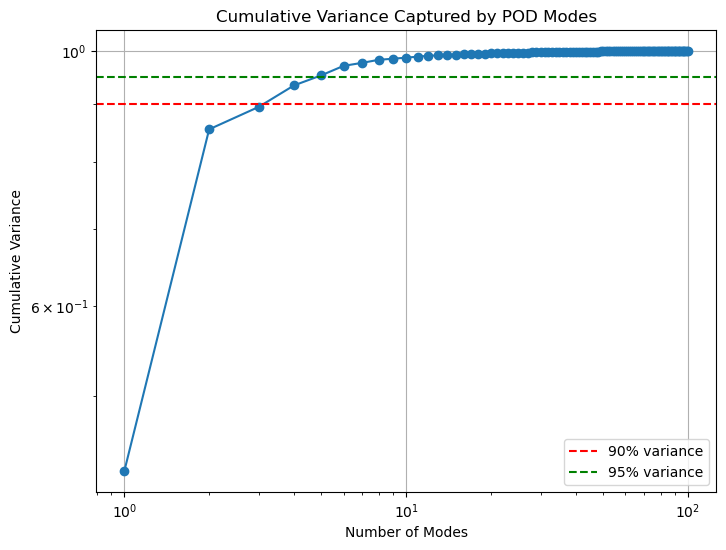

Number of modes to capture 90% variance: 4
Number of modes to capture 95% variance: 5
Number of modes to capture 99% variance: 12
Number of modes to capture 99.9% variance: 44


In [11]:
# Assuming 'Sigma' contains the singular values from SVD

# Compute the variance captured by each mode
variance_captured = Sigma**2 / np.sum(Sigma**2)

# Compute the cumulative variance
cumulative_variance = np.cumsum(variance_captured)

# Plot cumulative variance
plt.figure(figsize=(8, 6))
plt.loglog(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(0.9, color='r', linestyle='--', label='90% variance')
plt.axhline(0.95, color='g', linestyle='--', label='95% variance')
plt.title('Cumulative Variance Captured by POD Modes')
plt.xlabel('Number of Modes')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.legend()
plt.show()

# Optionally print the number of modes needed for 90% and 95% variance
n_modes_90 = np.searchsorted(cumulative_variance, 0.9) + 1
n_modes_95 = np.searchsorted(cumulative_variance, 0.95) + 1
n_modes_99 = np.searchsorted(cumulative_variance, 0.99) + 1
n_modes_999 = np.searchsorted(cumulative_variance, 0.999) + 1
print(f"Number of modes to capture 90% variance: {n_modes_90}")
print(f"Number of modes to capture 95% variance: {n_modes_95}")
print(f"Number of modes to capture 99% variance: {n_modes_99}")
print(f"Number of modes to capture 99.9% variance: {n_modes_999}")

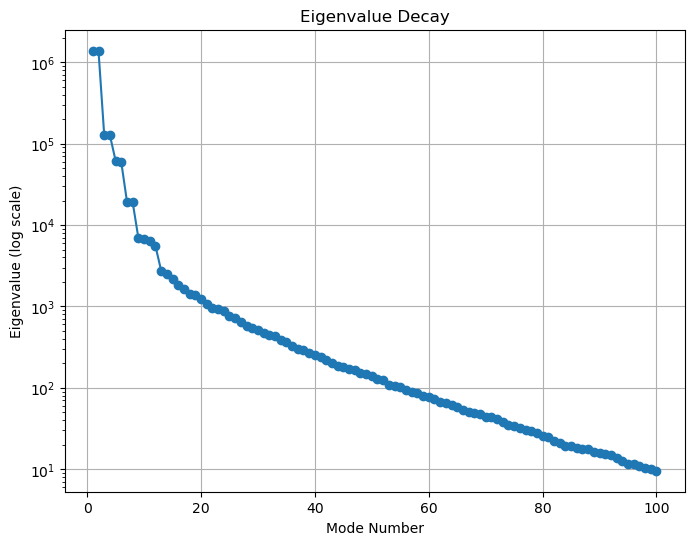

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'Sigma' contains the singular values from SVD

# Compute the eigenvalues (square of singular values)
eigenvalues = Sigma**2

# Plot eigenvalue decay
plt.figure(figsize=(8, 6))
plt.semilogy(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.title('Eigenvalue Decay')
plt.xlabel('Mode Number')
plt.ylabel('Eigenvalue (log scale)')
plt.grid(True)
plt.show()

In [13]:
import pandas as pd

# Assume:
# - 'd1_values' and 'beta_values' are arrays of parameters.
# - 't_values' is the array of time steps.
# - 'time_coefficients' is from SVD (shape: snapshots x modes).
# - 'num_samples', 'time_steps' are defined.



# Reshape d1 and beta to align with snapshots
d1_repeated = np.repeat(d1_values[:num_samples], time_steps)  # Repeat for all time steps
beta_repeated = np.repeat(beta_values[:num_samples], time_steps)  # Repeat for all time steps

# Tile the time array to align with snapshots
time_repeated = np.tile(t_values, num_samples)  # Tile for all samples

# Combine all inputs
inputs = np.vstack([d1_repeated, beta_repeated, time_repeated]).T  # Shape: (snapshots, 3)

# Combine inputs with coefficients (targets)
dataset = np.hstack([inputs])  # Shape: (snapshots, 3 + num_modes)

# Convert to DataFrame for easy manipulation
columns = ['d1', 'beta', 'time']
df = pd.DataFrame(dataset, columns=columns)

# Export to CSV
df.to_csv('pod_coefficients_dataset_usnapshots_32x32_coarse.csv', index=False)
print("Dataset exported to 'pod_coefficients_dataset.csv'.")

# Alternatively, save as HDF5


Dataset exported to 'pod_coefficients_dataset.csv'.


In [14]:
num_samples

50

In [15]:
d1_repeated = np.repeat(d1_values_test[:num_samples], time_steps)  # Repeat for all time steps
beta_repeated = np.repeat(beta_values_test[:num_samples], time_steps)  # Repeat for all time steps

# Tile the time array to align with snapshots
time_repeated = np.tile(t_values, num_samples)  # Tile for all samples

# Combine all inputs
inputs = np.vstack([d1_repeated, beta_repeated, time_repeated]).T  # Shape: (snapshots, 3)

# Combine inputs with coefficients (targets)
dataset = np.hstack([inputs])  # Shape: (snapshots, 3 + num_modes)

# Convert to DataFrame for easy manipulation
columns = ['d1', 'beta', 'time']
df = pd.DataFrame(dataset, columns=columns)

# Export to CSV
df.to_csv('pod_coefficients_testing_dataset_usnapshots_32x32_coarse.csv', index=False)
print("Dataset exported to 'pod_coefficients_dataset.csv'.")

with h5py.File('pod_coefficients_testing_dataset_32x32_coarse.h5', 'w') as h5file:
    h5file.create_dataset('inputs', data=inputs)  # Parameters + time
    h5file.create_dataset('coefficients', data=time_coefficients)  # POD coefficients
print("Dataset exported to 'pod_coefficients_dataset.h5'.")

Dataset exported to 'pod_coefficients_dataset.csv'.
Dataset exported to 'pod_coefficients_dataset.h5'.


In [16]:
x_values.shape

(32,)

In [17]:
# Export the basis to an HDF5 file
with h5py.File('pod_basis_32x32_coarse.h5', 'w') as h5file:
    # Save POD modes (spatial basis)
    h5file.create_dataset('POD_modes', data=POD_modes)  # Shape: (grid_points, num_modes)
    
    # Save singular values
    h5file.create_dataset('singular_values', data=Sigma)  # Shape: (num_modes,)
    
    # Save spatial grid
    h5file.create_dataset('x', data=x_values)  # Shape: (n,)
    h5file.create_dataset('y', data=y_values)  # Shape: (n,)
    
    # Save metadata
    h5file.attrs['grid_size'] = len(x_values)  # Number of grid points along one dimension
    h5file.attrs['num_modes'] = POD_modes.shape[1]  # Number of modes saved

print("POD basis exported to 'pod_basis.h5'.")

POD basis exported to 'pod_basis.h5'.
